<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1TRNaCfYstvcIQqoUSdukYQGF6LuyL7Tv" width=600 height=320/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import torchvision.transforms as tt
import torch
import torch.nn as nn

from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from torchvision.utils import make_grid
from IPython.display import clear_output
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import LeaveOneOut, cross_val_score
from sklearn.manifold import TSNE

%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

> На локальном компе датасет подогнан под размер 128 на 128 в папке 'people2', чтобы не тратить время на это при обучении модели

In [2]:
DATA_DIR = 'people2'

In [3]:
def get_dataloader(image_size, batch_size, stats):
    """
    Builds dataloader for training data.
    Use tt.Compose and tt.Resize for transformations
    :param image_size: height and wdith of the image
    :param batch_size: batch_size of the dataloader
    :returns: DataLoader object 
    """
    train_ds = ImageFolder(
        DATA_DIR, 
        transform=tt.Compose([
            # tt.Resize(image_size),
            # tt.CenterCrop(image_size),
            tt.ToTensor(),
            tt.Normalize(*stats)
        ])
    )
    return DataLoader(train_ds, batch_size, shuffle=True)

In [4]:
image_size = 128
batch_size = 16
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_dl = get_dataloader(image_size, batch_size, stats)

In [5]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [6]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

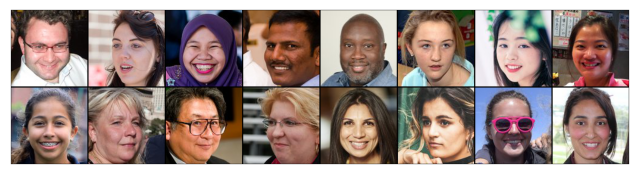

In [7]:
show_batch(train_dl)

In [9]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [10]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [12]:
latent_size = 128

Инициализация весов и архитектура модели взяты из туториала по pytorchю Архитектура немного подогнана под задачу

In [13]:
# Инициализация весов для генератора и дискриминатора
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # in: 3 x 128 x 128

            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 64 x 64

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout(0.4),
            # out: 128 x 32 x 32

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout(0.4),
            # out: 256 x 16 x 16

            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # nn.Dropout(0.4),
            # out: 512 x 8 x 8

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
            # out: 1 x 1 x 1

            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the Discriminator
netD = Discriminator().to(device)
    
# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(512, 1, kernel_size=(

In [16]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # in: latent_size x 1 x 1

            nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            # state size. (512) x 4 x 4
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # state size. (256) x 8 x 8
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # state size. (128) x 16 x 16
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # state size. (64) x 32 x 32
            nn.ConvTranspose2d(64, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # state size. (64) x 64 x 64
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # output size. (3) x 128 x 128
        )

    def forward(self, input):
        return self.main(input)

In [17]:
# Create the generator
netG = Generator().to(device)

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(128, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchNorm2d(

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [19]:
lr = 0.0002
epochs = 100

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Initialize the ``BCELoss`` function
criterionD = nn.MSELoss()
criterionG = nn.MSELoss()

На каждом батче дискриминатор делает один шаг, а генератор 2

In [21]:
def fit(netD, netG, criterionD, criterionG, epochs, lr, start_idx=1):
    netD.train()
    netG.train()
    torch.cuda.empty_cache()
    
    n_images = 4
    fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # определение размера буфера для генератора
    # buffer_size = 100

    # создание пустого буфера для генератора
    # buffer = []
        
    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            
            # Обучаем дискриминатор
            # Обнуляем градиенты
            optimizerD.zero_grad()

            # Прогоняем реальные картинки через дискриминатор
            real_preds = netD(real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device) - torch.rand(real_images.size(0), 1, device=device) * 0.05
            real_loss = criterionD(real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()
            
            # Генерируем картинки
            latent = torch.randn(real_images.size(0), latent_size, 1, 1, device=device)
            fake_images = netG(latent)

            # Добавляем фейковые изображения в буфер
            # buffer = add_to_buffer(buffer, fake_images, buffer_size)

            # Выбираем случайные изображения из буфера и используем их для обучения дискриминатора
            # sample_from_buffer = torch.stack([buffer[i] for i in torch.randint(len(buffer), (real_images.size(0),))])

            # Прогоняем выбранные картинки через дискриминатор
            fake_preds = netD(fake_images.detach())
            fake_targets = torch.zeros(real_images.size(0), 1, device=device) + torch.rand(real_images.size(0), 1, device=device) * 0.05
            fake_loss = criterionD(fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Обновляем веса дискриминатора
            loss_d = (real_loss + fake_loss) / 2
            loss_d.backward()
            optimizerD.step()
            loss_d_per_epoch.append(loss_d.item())


            # Обучаем генератор
            loss_g = 0
            for i in range(2):
                # Обнуляем градиенты
                optimizerG.zero_grad()

                # Генерируем картинки
                latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
                fake_images = netG(latent)

                # Пытаемся обмануть дискриминатор
                preds = netD(fake_images)
                targets = torch.ones(batch_size, 1, device=device)# - torch.rand(batch_size, 1, device=device) * 0.05
                loss = criterionG(preds, targets)
            
                # Обновляем веса генератора
                loss.backward()
                optimizerG.step()
                
                loss_g += loss
            loss_g_per_epoch.append(loss_g.item()/2)
        
        # Сохраняем оценки
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))
        
        clear_output(wait=True)
        # Log losses & scores (last batch)
        print(
            f'Epoch {epoch+1}/{epochs}, loss_g: {losses_g[-1]:.4f}, loss_d: {losses_d[-1]:.4f},   real_score: {real_scores[-1]:.4f}, fake_score: {fake_scores[-1]:.4f}'
            )
        
        fake_images = netG(fixed_latent)
        fig, ax = plt.subplots(figsize=(8, 2))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images.detach().cpu()), nrow=4).permute(1, 2, 0))
        plt.show()
    
    return losses_g, losses_d, real_scores, fake_scores

Epoch 100/100, loss_g: 0.8444, loss_d: 0.0375,   real_score: 0.8866, fake_score: 0.1136


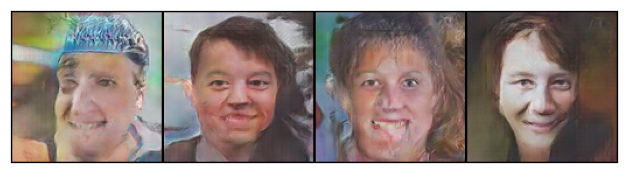

In [22]:
history = fit(netD, netG, criterionD, criterionG, epochs, lr)

In [23]:
losses_g, losses_d, real_scores, fake_scores = history

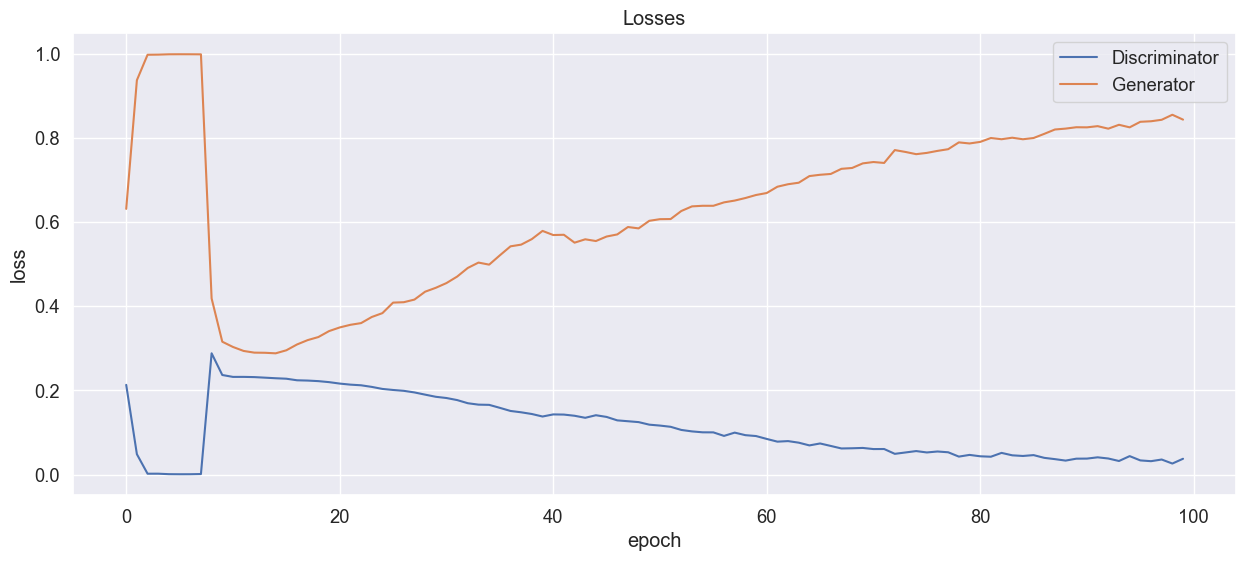

In [24]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

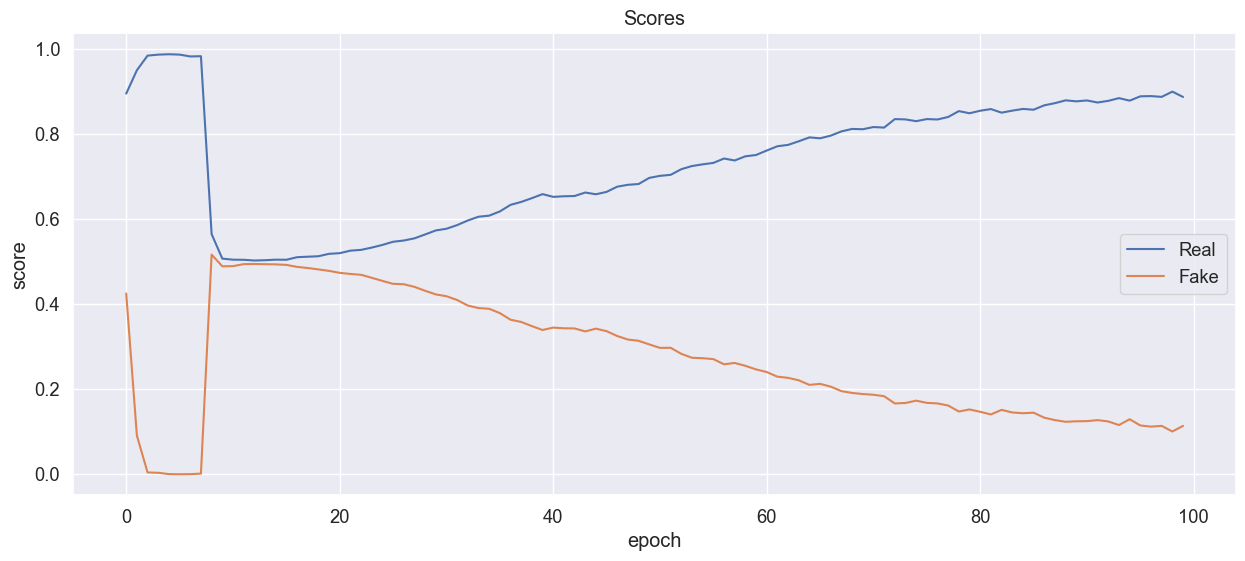

In [25]:
plt.figure(figsize=(15, 6))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [26]:
n_images = 32

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = netG(fixed_latent)

In [27]:
fake_images.shape

torch.Size([32, 3, 128, 128])

In [28]:
def show_images(generated):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(generated.detach().cpu()), nrow=8).permute(1, 2, 0))

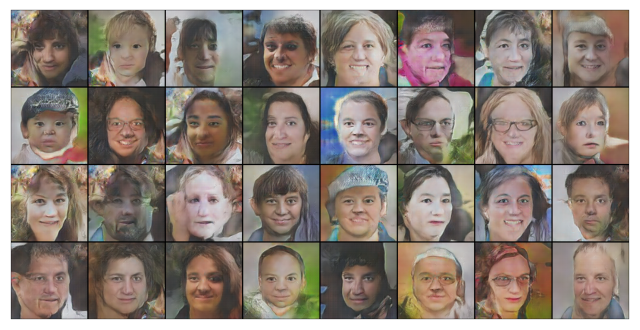

In [29]:
show_images(fake_images)

Как вам качество получившихся изображений?

Так себе )) Зато разнообразно

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [31]:
dataset = ImageFolder(
        DATA_DIR, 
        transform=tt.Compose([
            # tt.Resize(image_size),
            # tt.CenterCrop(image_size),
            tt.ToTensor(),
            tt.Normalize(*stats)
        ])
    )

In [106]:
# Итерируемся по датасету и сохраняем картинки в список
images = []
for image, label in dataset:
    images.append(image.numpy())
    
labels = [1 for _ in range(len(images))]

In [107]:
len(images)

3143

In [108]:
fake_images = []
for i in tqdm(range(len(images)//16)):
    latent = torch.randn(16, latent_size, 1, 1, device=device)
    imgs = netG(latent)
    fake_images.extend(imgs.detach().cpu().numpy())
    
latent = torch.randn(len(images)%16, latent_size, 1, 1, device=device)
imgs = netG(latent)
fake_images.extend(imgs.detach().cpu().numpy())
len(fake_images)

  0%|          | 0/196 [00:00<?, ?it/s]

3143

In [109]:
# Собираем вместе все картинки и метки классов
all_images = np.concatenate((images, fake_images), axis=0)
labels.extend([0 for _ in range(len(fake_images))])
labels = np.array(labels)

In [110]:
all_images.shape

(6286, 3, 128, 128)

In [111]:
features = all_images.reshape(-1,  3*128*128)

In [112]:
features.shape

(6286, 49152)

In [113]:
# Инициализация модели
model = KNeighborsClassifier(n_neighbors=1)

# Оценка качества с помощью LOO
scores = cross_val_score(model, features, labels, cv=loo.split(features), n_jobs=-1, verbose=2)

# Вычисление среднего значения и стандартного отклонения оценок качества
mean_score = scores.mean()
std_score = scores.std()

print('Среднее значение оценки качества:', mean_score)
print('Стандартное отклонение оценок качества:', std_score)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 19.6min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 26.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 35.2min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 55.2min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 66.9min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 80.3min
[Parallel(n_jobs=-1)]: Done 6286 out of 6286 | elapsed: 87.0min finished


Среднее значение оценки качества: 0.6065860642698059
Стандартное отклонение оценок качества: 0.4885073294265633


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

Довольно хорошая оценка получается. Лучше всего было бы 0.5 - значит классификатор не увидел бы разницу между сгенерированными картинками и реальными. А так он немного лучше угадывает где реальные картинки.

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

In [115]:
embedings = TSNE(n_components=2).fit_transform(features)

In [116]:
data = np.concatenate((embedings, labels[:, np.newaxis]), axis=1)
data

array([[  9.7395649 , -17.1856842 ,   1.        ],
       [-42.12926865, -12.0991888 ,   1.        ],
       [ 46.50834274,  12.27546978,   1.        ],
       ...,
       [-12.40209389, -16.7866497 ,   0.        ],
       [ 42.04556656,   6.51273727,   0.        ],
       [-35.74304199, -15.50411606,   0.        ]])

In [117]:
df = pd.DataFrame(data)
df.columns = ['x', 'y', 'label']
df['label'] = df['label'].astype('int')
df

,x,y,label
0,9.739565,-17.185684,1
1,-42.129269,-12.099189,1
2,46.508343,12.275470,1
3,-49.776348,-1.552315,1
4,-25.838490,29.263618,1
...,...,...,...
6281,16.349113,22.052933,0
6282,22.486862,-27.793993,0
6283,-12.402094,-16.786650,0
6284,42.045567,6.512737,0


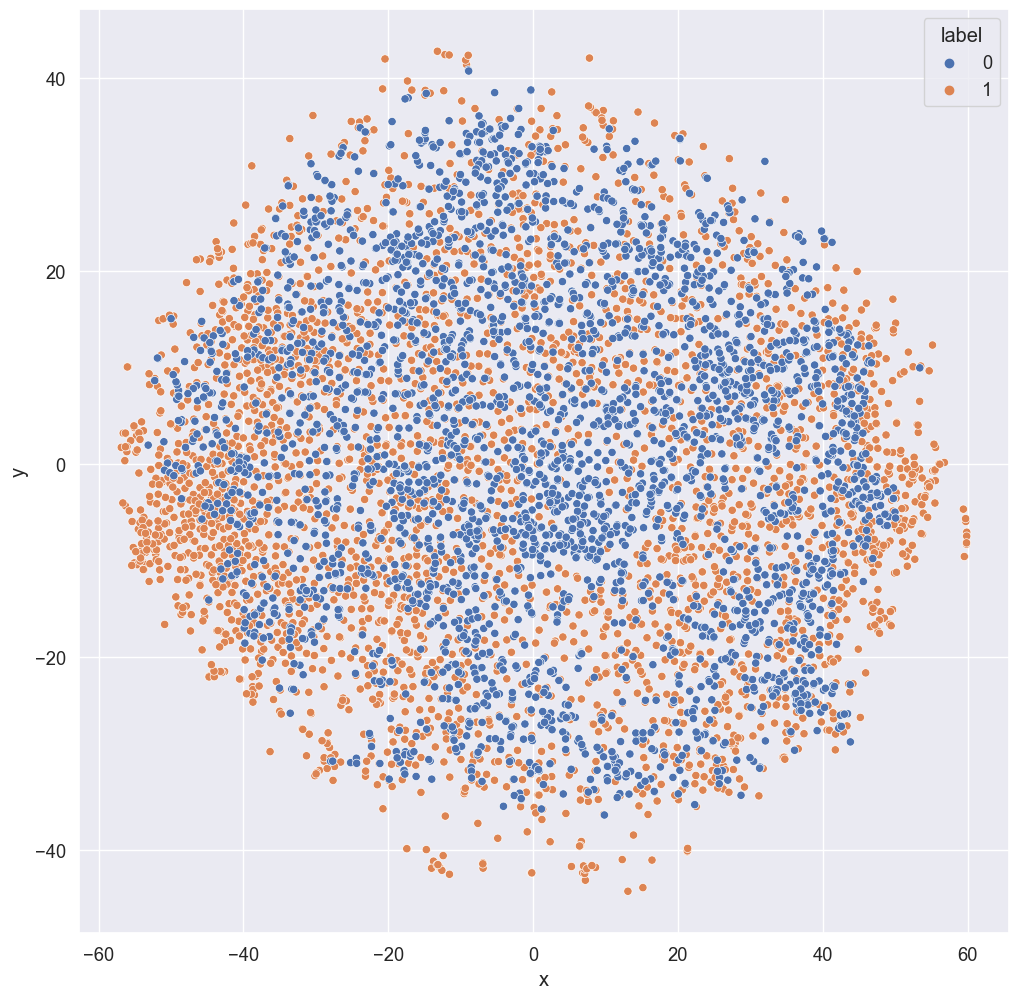

In [118]:
plt.figure(figsize=(12, 12))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette="deep");

Прокомментируйте получившийся результат:

Очень сильно похожие распределения